In [1]:
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import time
import pytz
import shapely
from shapely.geometry import Point, Polygon
from shapely import LineString
from shapely.wkt import loads
from datetime import datetime, timedelta
from pyproj import Proj
import pyproj
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import xml.etree.ElementTree as ET
import dask_geopandas as dgpd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from function import *

# Load

In [2]:
# Config
ROOT_PATH = r"D:\Chu's Document!\02 Project\06 道路塌陷防治專案(天坑)"

In [3]:
# function
def calculate_gdf_area(gdf_1, gdf_2, how='intersection', col='sample'):
    # Overlay the two GeoDataFrames
    temp = gpd.overlay(gdf_1, gdf_2, how=how)
    
    # Calculate road area grouped by village
    temp_area = temp.groupby('village')['geometry'].apply(lambda x: x.unary_union.area)
    gdf_1[col] = gdf_1['village'].map(temp_area)
    gdf_1[col] = gdf_1[col].fillna(0)
    return gdf_1

def dissolve_gdf(gdf, keep_col=["id", "geometry"]):
    """
    Dissolve a GeoDataFrame based on geometry.

    Parameters:
    - gdf (GeoDataFrame): The input GeoDataFrame to be dissolved.
    - keep_col (list): A list of column names to keep in the dissolved GeoDataFrame.

    Returns:
    - GeoDataFrame: The dissolved GeoDataFrame.
    """
    # Check missing values
    gdf = gdf[keep_col].copy()
    print(gdf.isnull().sum())

    # Check polygon validity and fix
    gdf['geometry'] = gdf['geometry'].buffer(0)

    # Dissolve
    dissolved_gdf = gdf.dissolve()
    print(dissolved_gdf.head())
    return dissolved_gdf

In [4]:
# Village border
raw_vil_path = ROOT_PATH + r"\03 Data\Raw\村里界\VILLAGE_NLSC_1120317.shp"
raw_vil = gpd.read_file(raw_vil_path, encoding='utf-8')
raw_vil = raw_vil.to_crs(epsg=3826)

# Road
# 大於8m道路
above_8m_road_raw_path = ROOT_PATH + r"\03 Data\Raw\臺北市寬度超過8公尺道路GIS檔\Road.shp"
above_8m_road_raw = gpd.read_file(above_8m_road_raw_path)
above_8m_road = above_8m_road_raw.copy()
above_8m_road = above_8m_road.to_crs(epsg=3826)

# 小於8m道路
under_8m_road_raw_path = ROOT_PATH + r"\01 QGIS\00 Processed Data\Geopackage\TP_Road_less_than_8m.gpkg"
under_8m_road_raw = gpd.read_file(under_8m_road_raw_path)
under_8m_road = under_8m_road_raw.copy()
under_8m_road = under_8m_road.to_crs(epsg=3826)

# 都市計畫使用分區
raw_urban_plan_path = ROOT_PATH + r"\03 Data\Raw\都市計畫使用分區\臺北市使用分區細計圖(對外)-面.shp"
urban_plan_raw = gpd.read_file(raw_urban_plan_path, encoding='big5')
urban_plan = urban_plan_raw.copy()
urban_plan.crs = 'epsg:3826'
urban_plan = urban_plan.to_crs(epsg=3826)

# Green space: school greening
raw_school_greening_path = ROOT_PATH + r"\03 Data\Raw\鋪面\公園綠地_校園綠化.geojson"
school_greening_raw = gpd.read_file(raw_school_greening_path)
school_greening = school_greening_raw.copy()
school_greening = school_greening.to_crs(epsg=3826)

# Green space: riverside highland
raw_riverside_highland_path = ROOT_PATH + r"\03 Data\Raw\鋪面\公園綠地_河濱高灘地.geojson"
riverside_highland_raw = gpd.read_file(raw_riverside_highland_path)
riverside_highland = riverside_highland_raw.copy()
riverside_highland = riverside_highland.to_crs(epsg=3826)

# Green space: birds conservation
raw_birds_conservation_path = ROOT_PATH + r"\03 Data\Raw\鋪面\都市綠地_野雁保護區.geojson"
birds_conservation_raw = gpd.read_file(raw_birds_conservation_path)
birds_conservation = birds_conservation_raw.copy()
birds_conservation = birds_conservation.to_crs(epsg=3826)

# Green space: agriculture area
raw_agriculture_area_path = ROOT_PATH + r"\03 Data\Raw\鋪面\都市綠地_都市計畫保護區、農業區.geojson"
agriculture_area_raw = gpd.read_file(raw_agriculture_area_path)
agriculture_area = agriculture_area_raw.copy()
agriculture_area = agriculture_area.to_crs(epsg=3826)

# 土壤液化趨勢
soil_liquid_raw_path = ROOT_PATH + r"\01 QGIS\00 Processed Data\Geopackage\土壤液化潛勢_dissolved_class.gpkg"
soil_liquid_raw = gpd.read_file(soil_liquid_raw_path)
soil_liquid = soil_liquid_raw.copy()
soil_liquid = soil_liquid.to_crs(epsg=3826)

# 道路案件(108-112年新工處資料(璿達去重&威竹加標記))
road_case_raw = pd.read_csv(ROOT_PATH + r"\03 Data\Processed\道管系統坑洞案件_108-112_Chu加案件標記_20240201.csv")
road_case = road_case_raw.copy()

# Permeable pavement PAC
pavement_pac_raw_path = ROOT_PATH + r"\03 Data\Raw\鋪面\透水鋪面_PAC鋪面.geojson"
pavement_pac_raw = gpd.read_file(pavement_pac_raw_path)
pavement_pac = pavement_pac_raw.copy()
pavement_pac = pavement_pac.to_crs(epsg=3826)

# Permeable pavement sidewalk
pavement_sidewalk_raw_path = ROOT_PATH + r"\03 Data\Raw\鋪面\透水鋪面_人行道透水鋪面.geojson"
pavement_sidewalk_raw = gpd.read_file(pavement_sidewalk_raw_path)
pavement_sidewalk = pavement_sidewalk_raw.copy()
pavement_sidewalk = pavement_sidewalk.to_crs(epsg=3826)

# Permeable pavement parkinglot
pavement_parkinglot_raw_path = ROOT_PATH + r"\03 Data\Raw\鋪面\透水鋪面_停車場透水鋪面.geojson"
pavement_parkinglot_raw = gpd.read_file(pavement_parkinglot_raw_path)
pavement_parkinglot = pavement_parkinglot_raw.copy()
pavement_parkinglot = pavement_parkinglot.to_crs(epsg=3826)

# Permeable pavement park
pavement_park_raw_path = ROOT_PATH + r"\03 Data\Raw\鋪面\透水鋪面_公園透水鋪面.geojson"
pavement_park_raw = gpd.read_file(pavement_park_raw_path)
pavement_park = pavement_park_raw.copy()
pavement_park = pavement_park.to_crs(epsg=3826)

# Permeable pavement school
pavement_school_raw_path = ROOT_PATH + r"\03 Data\Raw\鋪面\透水鋪面_學校透水鋪面.geojson"
pavement_school_raw = gpd.read_file(pavement_school_raw_path)
pavement_school = pavement_school_raw.copy()
pavement_school = pavement_school.to_crs(epsg=3826)

# Data preprocess

## Village selection
- 篩選台北市範圍內的里
- 計算各里包含到土壤液化潛勢的面積佔比
- 計算該里內的道路面積、公園用地面積、透水鋪面面積
- 計算道路案件累計數量、判定天坑累計數量
- 計算各類型鋪面佔比
- 確認天坑數量、道路案件與各類型鋪面是否有相關性

In [5]:
tp_vil = raw_vil[raw_vil['COUNTYNAME'] == '臺北市']
keep_col = ['TOWNNAME', 'VILLNAME', 'VILLCODE', 'geometry']
tp_vil = tp_vil[keep_col]
tp_vil = tp_vil.rename(columns={'TOWNNAME': 'town', 'VILLNAME': 'village', 'VILLCODE': 'vil_code'})
tp_vil['vil_area'] = tp_vil['geometry'].area
tp_vil.head()

,town,village,vil_code,geometry,vil_area
136,南港區,西新里,63000090008,"POLYGON ((309803.669 2772329.942, 309896.039 2...",4.699368e+05
137,南港區,重陽里,63000090020,"POLYGON ((310038.796 2772556.157, 310098.384 2...",3.853900e+05
138,內湖區,蘆洲里,63000100037,"POLYGON ((311631.369 2773130.775, 311633.200 2...",7.718843e+05
139,內湖區,石潭里,63000100028,"POLYGON ((310899.967 2773360.726, 310900.238 2...",1.167094e+06
4664,中山區,朱園里,63000040036,"POLYGON ((303958.754 2771642.927, 304161.596 2...",2.767043e+05


In [6]:
tp_vil.shape

(456, 5)

## Soil liquid

In [7]:
# replace legend
soil_replace = {"1":2, "2":1,"3":0}
soil_liquid['class'] = soil_liquid['class'].replace(soil_replace)

In [8]:
# Calculate area of each class
temp_soil = gpd.overlay(tp_vil, soil_liquid, how='intersection')

# Class 0
area_class_0 = temp_soil[temp_soil['class'] == 0].groupby('village')['geometry'].apply(lambda x: x.unary_union.area)
tp_vil['soil_class_0'] = tp_vil['village'].map(area_class_0)
tp_vil['soil_class_0'] = tp_vil['soil_class_0'].fillna(0)

# Class 1
area_class_1 = temp_soil[temp_soil['class'] == 1].groupby('village')['geometry'].apply(lambda x: x.unary_union.area)
tp_vil['soil_class_1'] = tp_vil['village'].map(area_class_1)
tp_vil['soil_class_1'] = tp_vil['soil_class_1'].fillna(0)

# Class 2
area_class_2 = temp_soil[temp_soil['class'] == 2].groupby('village')['geometry'].apply(lambda x: x.unary_union.area)
tp_vil['soil_class_2'] = tp_vil['village'].map(area_class_2)
tp_vil['soil_class_2'] = tp_vil['soil_class_2'].fillna(0)
tp_vil

,town,village,vil_code,geometry,vil_area,soil_class_0,soil_class_1,soil_class_2
136,南港區,西新里,63000090008,"POLYGON ((309803.669 2772329.942, 309896.039 2...",4.699368e+05,39662.985576,395612.887058,4561.678611
137,南港區,重陽里,63000090020,"POLYGON ((310038.796 2772556.157, 310098.384 2...",3.853900e+05,0.000000,257808.889730,41461.907522
138,內湖區,蘆洲里,63000100037,"POLYGON ((311631.369 2773130.775, 311633.200 2...",7.718843e+05,15214.001973,452334.761731,171249.999997
139,內湖區,石潭里,63000100028,"POLYGON ((310899.967 2773360.726, 310900.238 2...",1.167094e+06,92279.768490,803117.694042,0.000000
4664,中山區,朱園里,63000040036,"POLYGON ((303958.754 2771642.927, 304161.596 2...",2.767043e+05,0.000000,170874.863796,105829.432146
...,...,...,...,...,...,...,...,...
7691,北投區,泉源里,63000120039,"POLYGON ((302332.607 2784355.092, 302365.510 2...",5.026642e+06,0.000000,0.000000,0.000000
7692,士林區,平等里,63000110048,"POLYGON ((308170.928 2784399.922, 308194.655 2...",6.417083e+06,0.000000,0.000000,0.000000
7693,北投區,大屯里,63000120041,"POLYGON ((300710.056 2785069.337, 300738.995 2...",4.329053e+06,0.000000,0.000000,0.000000
7694,士林區,菁山里,63000110047,"POLYGON ((308542.775 2787541.572, 308555.720 2...",1.172246e+07,0.000000,0.000000,0.000000


## Road area

In [9]:
# Reduce columns for above 8m road
keep_col = ['Road_ID', 'geometry']
above_8m_road_keep = above_8m_road[keep_col].copy()
above_8m_road_keep.dropna(subset=['Road_ID'], inplace=True)
print(above_8m_road_keep.head())

# Reduce columns of under 8m road
keep_col = ['ROADID', 'geometry']
under_8m_road_keep = under_8m_road[keep_col].copy()
under_8m_road_keep.dropna(subset=['ROADID'], inplace=True)
under_8m_road_keep = under_8m_road_keep.rename(columns={'ROADID': 'Road_ID'})
print(under_8m_road_keep.head())

   Road_ID                                           geometry
0   南深路-31  POLYGON ((312926.002 2767938.202, 312917.571 2...
1  115-310  POLYGON ((312929.425 2767945.142, 312928.494 2...
2  115-309  POLYGON ((312825.291 2768047.351, 312827.474 2...
3   南深路-30  POLYGON ((312868.896 2768055.090, 312872.430 2...
4   南深路-29  POLYGON ((312795.244 2768136.747, 312796.006 2...
    Road_ID                                           geometry
0  A0000001  MULTIPOLYGON (((309672.010 2772835.184, 309674...
1  A0000002  MULTIPOLYGON (((309635.242 2772889.613, 309639...
2  A0000003  MULTIPOLYGON (((309648.575 2772736.889, 309654...
3  A0000007  MULTIPOLYGON (((309487.439 2772754.521, 309510...
4  A0000008  MULTIPOLYGON (((309505.655 2772694.708, 309451...


In [10]:
# Concate above 8m and under 8m road
road_all = pd.concat([above_8m_road_keep, under_8m_road_keep], axis=0)
road_all = road_all.reset_index(drop=True)
print(road_all.shape)

# Dissolve
road_all = road_all.dissolve()  # 19s
print(road_all.head())

(40651, 2)
                                            geometry Road_ID
0  MULTIPOLYGON (((297705.093 2776726.720, 297658...  南深路-31


<Axes: >

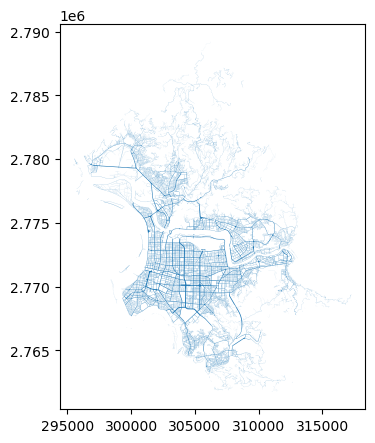

In [11]:
road_all.plot(figsize=(5, 5))

In [12]:
# Overlay
tp_vil = calculate_gdf_area(tp_vil, road_all, how='intersection', col='road_area')
tp_vil.head()

,town,village,vil_code,geometry,vil_area,soil_class_0,soil_class_1,soil_class_2,road_area
136,南港區,西新里,63000090008,"POLYGON ((309803.669 2772329.942, 309896.039 2...",4.699368e+05,39662.985576,395612.887058,4561.678611,75869.103977
137,南港區,重陽里,63000090020,"POLYGON ((310038.796 2772556.157, 310098.384 2...",3.853900e+05,0.000000,257808.889730,41461.907522,75639.066848
138,內湖區,蘆洲里,63000100037,"POLYGON ((311631.369 2773130.775, 311633.200 2...",7.718843e+05,15214.001973,452334.761731,171249.999997,80334.703154
139,內湖區,石潭里,63000100028,"POLYGON ((310899.967 2773360.726, 310900.238 2...",1.167094e+06,92279.768490,803117.694042,0.000000,187002.700199
4664,中山區,朱園里,63000040036,"POLYGON ((303958.754 2771642.927, 304161.596 2...",2.767043e+05,0.000000,170874.863796,105829.432146,85807.651753


## Green space

### Park 

In [13]:
# Drop missing value
urban_plan = urban_plan.dropna(subset=['使用分區'])

# Check missing value
print(urban_plan.isnull().sum())

編號              0
分區簡稱            0
使用分區            0
分區說明        15396
原屬分區        15192
geometry        0
dtype: int64


In [14]:
# Filter park
mask = urban_plan['使用分區'].str.contains('公園')
urban_park = urban_plan[mask]
print(urban_park.shape, urban_plan.shape)

# Overlay
tp_vil = calculate_gdf_area(tp_vil, urban_park, how='intersection', col='park_area')
tp_vil.head()

(849, 6) (15509, 6)


,town,village,vil_code,geometry,vil_area,soil_class_0,soil_class_1,soil_class_2,road_area,park_area
136,南港區,西新里,63000090008,"POLYGON ((309803.669 2772329.942, 309896.039 2...",4.699368e+05,39662.985576,395612.887058,4561.678611,75869.103977,29854.157796
137,南港區,重陽里,63000090020,"POLYGON ((310038.796 2772556.157, 310098.384 2...",3.853900e+05,0.000000,257808.889730,41461.907522,75639.066848,9966.735300
138,內湖區,蘆洲里,63000100037,"POLYGON ((311631.369 2773130.775, 311633.200 2...",7.718843e+05,15214.001973,452334.761731,171249.999997,80334.703154,2491.296476
139,內湖區,石潭里,63000100028,"POLYGON ((310899.967 2773360.726, 310900.238 2...",1.167094e+06,92279.768490,803117.694042,0.000000,187002.700199,182700.761062
4664,中山區,朱園里,63000040036,"POLYGON ((303958.754 2771642.927, 304161.596 2...",2.767043e+05,0.000000,170874.863796,105829.432146,85807.651753,5798.350137


### School greening

In [15]:
# Check missing value
keep_col = ["id", "geometry"]
school_greening = school_greening[keep_col].copy()
print(school_greening.isnull().sum())

# Check polygon valid
school_greening['geometry'] = school_greening['geometry'].buffer(0)

# Dissolve
school_greening = school_greening.dissolve()
print(school_greening.head())

# Overlay
tp_vil = calculate_gdf_area(tp_vil, school_greening, how='intersection', col='school_greening_area')
tp_vil.head(1)

id          0
geometry    0
dtype: int64
                                            geometry         id
0  MULTIPOLYGON (((282761.400 2767106.131, 282761...  L0401-1.1


,town,village,vil_code,geometry,vil_area,soil_class_0,soil_class_1,soil_class_2,road_area,park_area,school_greening_area
136,南港區,西新里,63000090008,"POLYGON ((309803.669 2772329.942, 309896.039 2...",469936.848346,39662.985576,395612.887058,4561.678611,75869.103977,29854.157796,0.0


### Birds conservation

In [16]:
# Check missing value
keep_col = ["id", "geometry"]
riverside_highland = birds_conservation[keep_col].copy()
print(birds_conservation.isnull().sum())

# Check polygon valid
birds_conservation['geometry'] = birds_conservation['geometry'].buffer(0)

# Dissolve
birds_conservation = birds_conservation.dissolve()
print(birds_conservation.head())

# Overlay
tp_vil = calculate_gdf_area(tp_vil, birds_conservation, how='intersection', col='birds_conservation_area')
tp_vil.head(1)

id          0
項次          0
名稱          0
面積          0
體積          0
圖形          0
geometry    0
dtype: int64
                                            geometry         id 項次     名稱  \
0  POLYGON ((301546.531 2768326.798, 301554.268 2...  I0201-5.1  1  雁鴨保護區   

              面積 體積 圖形  
0  1799444.06685  0  面  


,town,village,vil_code,geometry,vil_area,soil_class_0,soil_class_1,soil_class_2,road_area,park_area,school_greening_area,birds_conservation_area
136,南港區,西新里,63000090008,"POLYGON ((309803.669 2772329.942, 309896.039 2...",469936.848346,39662.985576,395612.887058,4561.678611,75869.103977,29854.157796,0.0,0.0


### Riverside highland

In [17]:
# Check missing value
keep_col = ["id", "geometry"]
riverside_highland = riverside_highland[keep_col].copy()
print(riverside_highland.isnull().sum())

# Check polygon valid
riverside_highland['geometry'] = riverside_highland['geometry'].buffer(0)

# Dissolve
riverside_highland = riverside_highland.dissolve()
print(riverside_highland.head())

# Overlay
tp_vil = calculate_gdf_area(tp_vil, riverside_highland, how='intersection', col='riverside_highland_area')
tp_vil.head(1)

id          0
geometry    0
dtype: int64
                                            geometry         id
0  POLYGON ((301546.531 2768326.798, 301554.268 2...  I0201-5.1


,town,village,vil_code,geometry,vil_area,soil_class_0,soil_class_1,soil_class_2,road_area,park_area,school_greening_area,birds_conservation_area,riverside_highland_area
136,南港區,西新里,63000090008,"POLYGON ((309803.669 2772329.942, 309896.039 2...",469936.848346,39662.985576,395612.887058,4561.678611,75869.103977,29854.157796,0.0,0.0,0.0


### Agriculture area

In [18]:
# Check missing value
keep_col = ["id", "geometry"]
agriculture_area = agriculture_area[keep_col].copy()
print(agriculture_area.isnull().sum())

# Check polygon valid
agriculture_area['geometry'] = agriculture_area['geometry'].buffer(0)

# Dissolve
agriculture_area = agriculture_area.dissolve()
print(agriculture_area.head())

# Overlay
tp_vil = calculate_gdf_area(tp_vil, agriculture_area, how='intersection', col='agriculture_area')
tp_vil.head(1)

id          0
geometry    0
dtype: int64
                                            geometry         id
0  MULTIPOLYGON (((303902.583 2773638.064, 303843...  I0301-5.1


,town,village,vil_code,geometry,vil_area,soil_class_0,soil_class_1,soil_class_2,road_area,park_area,school_greening_area,birds_conservation_area,riverside_highland_area,agriculture_area
136,南港區,西新里,63000090008,"POLYGON ((309803.669 2772329.942, 309896.039 2...",469936.848346,39662.985576,395612.887058,4561.678611,75869.103977,29854.157796,0.0,0.0,0.0,0.0


## Permeable pavement

In [19]:
# Pavement school
pavement_school = dissolve_gdf(pavement_school, keep_col=["id", "geometry"])
tp_vil = calculate_gdf_area(tp_vil, pavement_school, how='intersection', col='pavement_school_area')
tp_vil.head(1)

id          0
geometry    0
dtype: int64
                                            geometry         id
0  MULTIPOLYGON (((300317.725 2768436.578, 300294...  J0501-5.1


,town,village,vil_code,geometry,vil_area,soil_class_0,soil_class_1,soil_class_2,road_area,park_area,school_greening_area,birds_conservation_area,riverside_highland_area,agriculture_area,pavement_school_area
136,南港區,西新里,63000090008,"POLYGON ((309803.669 2772329.942, 309896.039 2...",469936.848346,39662.985576,395612.887058,4561.678611,75869.103977,29854.157796,0.0,0.0,0.0,0.0,0.0


In [20]:
# Pavement park
pavement_park = dissolve_gdf(pavement_park, keep_col=["id", "geometry"])
tp_vil = calculate_gdf_area(tp_vil, pavement_park, how='intersection', col='pavement_park_area')
tp_vil.head(1)

id          0
geometry    0
dtype: int64
                                            geometry         id
0  MULTIPOLYGON (((300718.977 2768229.216, 300848...  J0301-3.1


,town,village,vil_code,geometry,vil_area,soil_class_0,soil_class_1,soil_class_2,road_area,park_area,school_greening_area,birds_conservation_area,riverside_highland_area,agriculture_area,pavement_school_area,pavement_park_area
136,南港區,西新里,63000090008,"POLYGON ((309803.669 2772329.942, 309896.039 2...",469936.848346,39662.985576,395612.887058,4561.678611,75869.103977,29854.157796,0.0,0.0,0.0,0.0,0.0,20643.944838


In [21]:
# Pavement parkinglot
pavement_parkinglot = dissolve_gdf(pavement_parkinglot, keep_col=["id", "geometry"])
tp_vil = calculate_gdf_area(tp_vil, pavement_parkinglot, how='intersection', col='pavement_parkinglot_area')
tp_vil.head(1)

id          0
geometry    0
dtype: int64
                                            geometry         id
0  MULTIPOLYGON (((304320.918 2765187.770, 304345...  J0401-5.1


,town,village,vil_code,geometry,vil_area,soil_class_0,soil_class_1,soil_class_2,road_area,park_area,school_greening_area,birds_conservation_area,riverside_highland_area,agriculture_area,pavement_school_area,pavement_park_area,pavement_parkinglot_area
136,南港區,西新里,63000090008,"POLYGON ((309803.669 2772329.942, 309896.039 2...",469936.848346,39662.985576,395612.887058,4561.678611,75869.103977,29854.157796,0.0,0.0,0.0,0.0,0.0,20643.944838,0.0


In [22]:
# Pavement sidewalk
pavement_sidewalk = dissolve_gdf(pavement_sidewalk, keep_col=["id", "geometry"])
tp_vil = calculate_gdf_area(tp_vil, pavement_sidewalk, how='intersection', col='pavement_sidewalk_area')
tp_vil.head(1)

id          0
geometry    0
dtype: int64


                                            geometry         id
0  MULTIPOLYGON (((299491.564 2768702.878, 299491...  J0201-5.1


,town,village,vil_code,geometry,vil_area,soil_class_0,soil_class_1,soil_class_2,road_area,park_area,school_greening_area,birds_conservation_area,riverside_highland_area,agriculture_area,pavement_school_area,pavement_park_area,pavement_parkinglot_area,pavement_sidewalk_area
136,南港區,西新里,63000090008,"POLYGON ((309803.669 2772329.942, 309896.039 2...",469936.848346,39662.985576,395612.887058,4561.678611,75869.103977,29854.157796,0.0,0.0,0.0,0.0,0.0,20643.944838,0.0,0.0


In [23]:
# Pavement PAC
"""
This data is MultuLinsString format, so we need to convert it to Polygon. Compared to the above 8m
road data, the road area overlayed by linestring is our taget area.
Link: https://nco.gov.taipei/News_Content.aspx?n=BB8CF6F431E10630&s=6E12AE8C21B59142
"""

# Find overlayed road polygon
overlayed_area = gpd.sjoin(above_8m_road_keep, pavement_pac, how='inner', predicate='intersects')
drop_col = ['id', '項次', '名稱', '面積', '體積', '圖形', 'index_right']
overlayed_area = overlayed_area.drop(columns=drop_col)

# Overlay
pavement_pac = dissolve_gdf(overlayed_area, keep_col=["Road_ID", "geometry"])
tp_vil = calculate_gdf_area(tp_vil, pavement_pac, how='intersection', col='pavement_pac_area')
tp_vil.head(1)

Road_ID     0
geometry    0
dtype: int64
                                            geometry    Road_ID
0  MULTIPOLYGON (((299387.494 2769145.753, 299383...  南京東路六段-10


,town,village,vil_code,geometry,vil_area,soil_class_0,soil_class_1,soil_class_2,road_area,park_area,school_greening_area,birds_conservation_area,riverside_highland_area,agriculture_area,pavement_school_area,pavement_park_area,pavement_parkinglot_area,pavement_sidewalk_area,pavement_pac_area
136,南港區,西新里,63000090008,"POLYGON ((309803.669 2772329.942, 309896.039 2...",469936.848346,39662.985576,395612.887058,4561.678611,75869.103977,29854.157796,0.0,0.0,0.0,0.0,0.0,20643.944838,0.0,0.0,0.0


## Road case count

In [24]:
# colemn cleaning
road_keep_col = [
    '案件編號', '查報日期', '道路寬度', 'link', 'lng_twd97', 
    'lat_twd97', '疑似天坑案件', 'TUIC天坑判斷'
]
road_case = road_case[road_keep_col]
road_case = road_case.dropna(subset=["lng_twd97"])

# Road case and sinkhole case count
road_case_out = road_case[road_case["TUIC天坑判斷"] != 2]
road_case_in = road_case[road_case["TUIC天坑判斷"] == 2]

# Create point gdf
road_case_out_gdf = gpd.GeoDataFrame(
    road_case_out, geometry=gpd.points_from_xy(road_case_out['lng_twd97'], road_case_out['lat_twd97'])
)
road_case_in_gdf = gpd.GeoDataFrame(road_case_in, geometry=gpd.points_from_xy(road_case_in['lng_twd97'], road_case_in['lat_twd97']))

# transfer to date
road_case_out_gdf["查報日期"] = pd.to_datetime(road_case_out_gdf["查報日期"])
road_case_out_gdf["查報日期"] = road_case_out_gdf["查報日期"].dt.date
road_case_in_gdf["查報日期"] = pd.to_datetime(road_case_in_gdf["查報日期"])
road_case_in_gdf["查報日期"] = road_case_in_gdf["查報日期"].dt.date

In [25]:
# Spatial join
drop_col = [
    '案件編號', '查報日期', '道路寬度', 'link', 'lng_twd97', 'lat_twd97', 
    '疑似天坑案件', 'TUIC天坑判斷', 
]
road_case_out_gdf.crs = 'epsg:3826'
temp = gpd.sjoin(tp_vil, road_case_out_gdf, how='left', predicate='contains')
temp = temp.drop(columns=drop_col)
temp = temp.dropna(subset=['index_right'])

# Counting
count_result = temp.groupby("village").size()
tp_vil['roadcase_count'] = tp_vil['village'].map(count_result)
tp_vil['roadcase_count'] = tp_vil['roadcase_count'].fillna(0)
tp_vil.head()

tp_vil.head()

,town,village,vil_code,geometry,vil_area,soil_class_0,soil_class_1,soil_class_2,road_area,park_area,school_greening_area,birds_conservation_area,riverside_highland_area,agriculture_area,pavement_school_area,pavement_park_area,pavement_parkinglot_area,pavement_sidewalk_area,pavement_pac_area,roadcase_count
136,南港區,西新里,63000090008,"POLYGON ((309803.669 2772329.942, 309896.039 2...",4.699368e+05,39662.985576,395612.887058,4561.678611,75869.103977,29854.157796,0.0,0.0,0.0,0.000000,0.0,20643.944838,0.0,0.000000,0.000000,170
137,南港區,重陽里,63000090020,"POLYGON ((310038.796 2772556.157, 310098.384 2...",3.853900e+05,0.000000,257808.889730,41461.907522,75639.066848,9966.735300,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1596.393306,0.000000,190
138,內湖區,蘆洲里,63000100037,"POLYGON ((311631.369 2773130.775, 311633.200 2...",7.718843e+05,15214.001973,452334.761731,171249.999997,80334.703154,2491.296476,0.0,0.0,0.0,104863.716415,0.0,0.000000,0.0,0.000000,0.000000,100
139,內湖區,石潭里,63000100028,"POLYGON ((310899.967 2773360.726, 310900.238 2...",1.167094e+06,92279.768490,803117.694042,0.000000,187002.700199,182700.761062,0.0,0.0,0.0,0.000000,0.0,72994.764852,0.0,42.623525,12432.460510,440
4664,中山區,朱園里,63000040036,"POLYGON ((303958.754 2771642.927, 304161.596 2...",2.767043e+05,0.000000,170874.863796,105829.432146,85807.651753,5798.350137,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,18.484455,71


In [26]:
# Spatial join
drop_col = [
    '案件編號', '查報日期', '道路寬度', 'link', 'lng_twd97', 'lat_twd97', 
    '疑似天坑案件', 'TUIC天坑判斷', 
]
road_case_in_gdf.crs = 'epsg:3826'
temp = gpd.sjoin(tp_vil, road_case_in_gdf, how='left', predicate='contains')
temp = temp.drop(columns=drop_col)
temp = temp.dropna(subset=['index_right'])

# Counting
count_result = temp.groupby("village").size()
tp_vil['sinkhole_count'] = tp_vil['village'].map(count_result)
tp_vil['sinkhole_count'] = tp_vil['sinkhole_count'].fillna(0)
tp_vil.head()

,town,village,vil_code,geometry,vil_area,soil_class_0,soil_class_1,soil_class_2,road_area,park_area,...,birds_conservation_area,riverside_highland_area,agriculture_area,pavement_school_area,pavement_park_area,pavement_parkinglot_area,pavement_sidewalk_area,pavement_pac_area,roadcase_count,sinkhole_count
136,南港區,西新里,63000090008,"POLYGON ((309803.669 2772329.942, 309896.039 2...",4.699368e+05,39662.985576,395612.887058,4561.678611,75869.103977,29854.157796,...,0.0,0.0,0.000000,0.0,20643.944838,0.0,0.000000,0.000000,170,5.0
137,南港區,重陽里,63000090020,"POLYGON ((310038.796 2772556.157, 310098.384 2...",3.853900e+05,0.000000,257808.889730,41461.907522,75639.066848,9966.735300,...,0.0,0.0,0.000000,0.0,0.000000,0.0,1596.393306,0.000000,190,0.0
138,內湖區,蘆洲里,63000100037,"POLYGON ((311631.369 2773130.775, 311633.200 2...",7.718843e+05,15214.001973,452334.761731,171249.999997,80334.703154,2491.296476,...,0.0,0.0,104863.716415,0.0,0.000000,0.0,0.000000,0.000000,100,0.0
139,內湖區,石潭里,63000100028,"POLYGON ((310899.967 2773360.726, 310900.238 2...",1.167094e+06,92279.768490,803117.694042,0.000000,187002.700199,182700.761062,...,0.0,0.0,0.000000,0.0,72994.764852,0.0,42.623525,12432.460510,440,0.0
4664,中山區,朱園里,63000040036,"POLYGON ((303958.754 2771642.927, 304161.596 2...",2.767043e+05,0.000000,170874.863796,105829.432146,85807.651753,5798.350137,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,18.484455,71,1.0


## Calculate percentage of each feature

In [27]:
# Calculate percentage
tp_vil['pct_soil_class_0'] = (tp_vil['soil_class_0'] / tp_vil['vil_area']).fillna(0)
tp_vil['pct_soil_class_1'] = (tp_vil['soil_class_1'] / tp_vil['vil_area']).fillna(0)
tp_vil['pct_soil_class_2'] = (tp_vil['soil_class_2'] / tp_vil['vil_area']).fillna(0)
tp_vil['pct_road_area'] = (tp_vil['road_area'] / tp_vil['vil_area']).fillna(0)
tp_vil['pct_park_area'] = (tp_vil['park_area'] / tp_vil['vil_area']).fillna(0)
tp_vil['pct_school_greening_area'] = (tp_vil['school_greening_area'] / tp_vil['vil_area']).fillna(0)
tp_vil['pct_birds_conservation_area'] = (tp_vil['birds_conservation_area'] / tp_vil['vil_area']).fillna(0)
tp_vil['pct_riverside_highland_area'] = (tp_vil['riverside_highland_area'] / tp_vil['vil_area']).fillna(0)
tp_vil['pct_agriculture_area'] = (tp_vil['agriculture_area'] / tp_vil['vil_area']).fillna(0)
tp_vil['pct_pavement_school_area'] = (tp_vil['pavement_school_area'] / tp_vil['vil_area']).fillna(0)
tp_vil['pct_pavement_park_area'] = (tp_vil['pavement_park_area'] / tp_vil['vil_area']).fillna(0)
tp_vil['pct_pavement_parkinglot_area'] = (tp_vil['pavement_parkinglot_area'] / tp_vil['vil_area']).fillna(0)
tp_vil['pct_pavement_sidewalk_area'] = (tp_vil['pavement_sidewalk_area'] / tp_vil['vil_area']).fillna(0)
tp_vil['pct_pavement_pac_area'] = (tp_vil['pavement_pac_area'] / tp_vil['vil_area']).fillna(0)
# tp_vil['pct_roadcase_count'] = (tp_vil['roadcase_count'] / tp_vil['vil_area']).fillna(0)
# tp_vil['pct_sinkhole_count'] = (tp_vil['sinkhole_count'] / tp_vil['vil_area']).fillna(0)

In [28]:
sort_col = ['town', 'village', 'vil_code', 'geometry', 'vil_area', 'soil_class_0',
    'soil_class_1', 'soil_class_2', 'road_area', 'park_area', 'school_greening_area', 
    'birds_conservation_area', 'riverside_highland_area', 'agriculture_area', 
    'pavement_school_area', 'pavement_park_area', 'pavement_parkinglot_area', 
    'pavement_sidewalk_area', 'pavement_pac_area', 'pct_soil_class_0', 'pct_soil_class_1',
    'pct_soil_class_2', 'pct_road_area', 'pct_park_area', 'pct_school_greening_area', 
    'pct_birds_conservation_area', 'pct_riverside_highland_area', 'pct_agriculture_area',
    'pct_pavement_school_area', 'pct_pavement_park_area', 'pct_pavement_parkinglot_area', 
    'pct_pavement_sidewalk_area', 'pct_pavement_pac_area', 'roadcase_count', 'sinkhole_count'
]
tp_vil = tp_vil[sort_col].copy()

In [29]:
tp_vil.head()

,town,village,vil_code,geometry,vil_area,soil_class_0,soil_class_1,soil_class_2,road_area,park_area,...,pct_birds_conservation_area,pct_riverside_highland_area,pct_agriculture_area,pct_pavement_school_area,pct_pavement_park_area,pct_pavement_parkinglot_area,pct_pavement_sidewalk_area,pct_pavement_pac_area,roadcase_count,sinkhole_count
136,南港區,西新里,63000090008,"POLYGON ((309803.669 2772329.942, 309896.039 2...",4.699368e+05,39662.985576,395612.887058,4561.678611,75869.103977,29854.157796,...,0.0,0.0,0.000000,0.0,0.043929,0.0,0.000000,0.000000,170,5.0
137,南港區,重陽里,63000090020,"POLYGON ((310038.796 2772556.157, 310098.384 2...",3.853900e+05,0.000000,257808.889730,41461.907522,75639.066848,9966.735300,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.004142,0.000000,190,0.0
138,內湖區,蘆洲里,63000100037,"POLYGON ((311631.369 2773130.775, 311633.200 2...",7.718843e+05,15214.001973,452334.761731,171249.999997,80334.703154,2491.296476,...,0.0,0.0,0.135854,0.0,0.000000,0.0,0.000000,0.000000,100,0.0
139,內湖區,石潭里,63000100028,"POLYGON ((310899.967 2773360.726, 310900.238 2...",1.167094e+06,92279.768490,803117.694042,0.000000,187002.700199,182700.761062,...,0.0,0.0,0.000000,0.0,0.062544,0.0,0.000037,0.010652,440,0.0
4664,中山區,朱園里,63000040036,"POLYGON ((303958.754 2771642.927, 304161.596 2...",2.767043e+05,0.000000,170874.863796,105829.432146,85807.651753,5798.350137,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000067,71,1.0


## Export

In [30]:
tp_vil.to_csv(ROOT_PATH + r"\03 Data\Processed\Pavement_analysis_tp_vil.csv", index=False)

# Analysis

In [31]:
# tp_vil = pd.read_csv(ROOT_PATH + r"\03 Data\Processed\Pavement_analysis_tp_vil.csv")

In [32]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb
from sklearn.metrics import (mean_squared_error, accuracy_score, confusion_matrix, 
                             classification_report, f1_score, roc_auc_score, roc_curve,
                             recall_score, precision_score, r2_score
)
from sklearn.model_selection import KFold
import numpy as np
import lightgbm as lgb
import seaborn as sns
import os
import optuna
import pickle
import gzip

In [33]:
def plot_confusion_matrix(actual_val, pred_val, title=None):
    confusion_matrix = pd.crosstab(actual_val, pred_val,
                                   rownames=['Actual'],
                                   colnames=['Predicted'])
    
    plot = sns.heatmap(confusion_matrix, annot=True, fmt=',.0f')
    
    if title is None:
        pass
    else:
        plot.set_title(title)
        
    # plt.show()

def plot_roc_curve(model, X_test, y_test):
    """
    繪製模型的 ROC 曲線並計算 ROC AUC 分數。

    Parameters:
    - model: 已經訓練好的分類模型，例如 XGBoost。
    - X_test: 測試集的特徵。
    - y_test: 測試集的目標變數。

    Returns:
    - None
    """
    # 使用模型預測測試集概率
    y_proba = model.predict_proba(X_test)[:, 1]

    # 計算 ROC 曲線的指標
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)

    # 計算 AUC 分數
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f'ROC AUC Score: {roc_auc}')

    # 繪製 ROC 曲線
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')  # 對角線
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    # plt.show()

def concatenate_csv_files(file_paths):
    """
    合併多個 CSV 檔案成一個 DataFrame。

    Parameters:
        file_paths (list): 包含多個 CSV 檔案路徑的列表。

    Returns:
        pd.DataFrame: 合併後的 DataFrame。
    """
    # 初始化一個空的 DataFrame
    concatenated_df = pd.DataFrame()

    # 迴圈讀取每個檔案並使用 pd.concat 整合到 DataFrame
    for file_path in file_paths:
        # 使用 pd.read_csv 讀取每個檔案
        current_df = pd.read_csv(file_path)

        # 使用 pd.concat 將目前的 DataFrame 與之前的合併
        concatenated_df = pd.concat([concatenated_df, current_df], ignore_index=True)

    return concatenated_df

def concatenate_csv_files_dask(file_paths):
    """
    合併多個 CSV 檔案成一個 Dask DataFrame。

    Parameters:
        file_paths (list): 包含多個 CSV 檔案路徑的列表。

    Returns:
        dask.dataframe.DataFrame: 合併後的 Dask DataFrame。
    """
    # 初始化一個空的 Dask DataFrame
    dask_dfs = []

    # 迴圈讀取每個檔案並將數據添加到 Dask DataFrame 列表
    for file_path in file_paths:
        # 使用 dask.dataframe.read_csv 讀取每個檔案，返回一個 Dask DataFrame
        current_dask_df = dd.read_csv(file_path)
        dask_dfs.append(current_dask_df)

    # 使用 dask.dataframe.concat 將 Dask DataFrame 列表合併成一個大 Dask DataFrame
    concatenated_dask_df = dd.concat(dask_dfs, axis=0)

    return concatenated_dask_df

### Data Preprocess

In [34]:
tp_vil.columns

Index(['town', 'village', 'vil_code', 'geometry', 'vil_area', 'soil_class_0',
       'soil_class_1', 'soil_class_2', 'road_area', 'park_area',
       'school_greening_area', 'birds_conservation_area',
       'riverside_highland_area', 'agriculture_area', 'pavement_school_area',
       'pavement_park_area', 'pavement_parkinglot_area',
       'pavement_sidewalk_area', 'pavement_pac_area', 'pct_soil_class_0',
       'pct_soil_class_1', 'pct_soil_class_2', 'pct_road_area',
       'pct_park_area', 'pct_school_greening_area',
       'pct_birds_conservation_area', 'pct_riverside_highland_area',
       'pct_agriculture_area', 'pct_pavement_school_area',
       'pct_pavement_park_area', 'pct_pavement_parkinglot_area',
       'pct_pavement_sidewalk_area', 'pct_pavement_pac_area', 'roadcase_count',
       'sinkhole_count'],
      dtype='object')

In [35]:
# Columns cleaning
tp_vil.loc[tp_vil['sinkhole_count'] == 5, 'sinkhole_count'] = 4 #Because there is only one village with 5 sinkhole count
X = tp_vil.iloc[:, 4:-1]
y = tp_vil.iloc[:, -1]


# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
# X_val = sc.transform(X_val)

### Optuna

In [59]:
def objective_xgb(trial):
    # 將參數空間設定為優化的範圍
    params = {
        'booster': 'dart',
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_state': 0,
        # 'scale_pos_weight': scale_pos_weight,
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'eval_metric':  'rmse', 
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'tree_method': 'hist',  # 啟用 GPU 加速
        'device': "cuda",
        # 'gpu_id': 1
    }
    # 使用 'objective' 參數指定損失函數
    
    # 創建 XGBoost 模型
    xgb_model_opt = XGBRegressor(**params)

    # 使用訓練資料訓練模型
    xgb_model_opt.fit(X_train, y_train)

    # 在验证集上计算均方根误差
    y_pred = xgb_model_opt.predict(X_val)
    
    # f1score = f1_score(y_val, y_pred, average='macro')
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return rmse

    # 計算 Recall 並返回
    # recall_xgb = recall_score(y_validation, y_val_pred)
    # return recall_xgb

In [60]:
# 創建 Optuna study
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

# 開始優化
study.optimize(objective_xgb, n_trials=200, n_jobs=4)

[I 2024-03-26 15:02:42,306] A new study created in memory with name: no-name-af64f059-424a-4bc5-815b-432c1e20d625
[I 2024-03-26 15:03:06,949] Trial 1 finished with value: 0.833068902689091 and parameters: {'n_estimators': 103, 'learning_rate': 0.12985036763080474, 'max_depth': 3, 'subsample': 0.8650378883528056, 'colsample_bytree': 0.8481972459249698, 'reg_alpha': 0.6299806270015632, 'reg_lambda': 0.48820645426267084}. Best is trial 1 with value: 0.833068902689091.
[I 2024-03-26 15:03:16,227] Trial 0 finished with value: 0.8391697108933301 and parameters: {'n_estimators': 121, 'learning_rate': 0.17128099081342907, 'max_depth': 4, 'subsample': 0.8897173871289956, 'colsample_bytree': 0.7849809458008921, 'reg_alpha': 0.2376015116028245, 'reg_lambda': 0.41448147372061783}. Best is trial 1 with value: 0.833068902689091.
[I 2024-03-26 15:03:30,312] Trial 2 finished with value: 0.7658476359494516 and parameters: {'n_estimators': 144, 'learning_rate': 0.28099144012699734, 'max_depth': 4, 'subs

In [61]:
# 獲取最佳參數
best_params = study.best_params
params_fix = {
        'booster': 'dart',
        'eval_metric':  'rmse', 
        'random_state': 0,
        # 'scale_pos_weight': scale_pos_weight,
        'tree_method': 'hist',  # 啟用 GPU 加速
        'device': "cuda",
        # 'gpu_id': 1
    }
best_params.update(params_fix)
print("Best Parameters:", best_params)

# 使用最佳參數創建最終模型
xgb_best_model = XGBRegressor(**best_params)
xgb_best_model.fit(X_train, y_train)

# 預測
y_pred_xgbbest = xgb_best_model.predict(X_test)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgbbest))
r_squared = r2_score(y_test, y_pred_xgbbest)
print(f"RMSE: {rmse}")
print(f"R^2: {r_squared}")

# recall = recall_score(y_test, y_pred_xgbbest, average='macro')
# f1 = f1_score(y_test, y_pred_xgbbest, average='macro')
# accuracy = accuracy_score(y_test, y_pred_xgbbest)
# precision = precision_score(y_test, y_pred_xgbbest, average='macro')
# print(f'Accuracy: {accuracy}')
# print(f'F1 Score: {f1}')
# print(f"Recall: {recall}")
# print(f"Precision: {precision}")
# print('訓練集 Accuracy: ',xgb_best_model.score(X_train,y_train))
# print('測試集 Accuracy: ',xgb_best_model.score(X_test,y_pred_xgbbest))

Best Parameters: {'n_estimators': 109, 'learning_rate': 0.12817751988949802, 'max_depth': 5, 'subsample': 0.8094987306176867, 'colsample_bytree': 0.8454362673791462, 'reg_alpha': 0.9987594549908279, 'reg_lambda': 0.657242991929614, 'booster': 'dart', 'eval_metric': 'rmse', 'random_state': 0, 'tree_method': 'hist', 'device': 'cuda'}
RMSE: 0.7014165290626044
R^2: -0.1254492665562832


In [62]:
y.value_counts()

sinkhole_count
0.0    344
1.0     81
2.0     19
3.0     11
4.0      1
Name: count, dtype: int64

### KFold

In [63]:
# 定义 KFold 对象，将数据分成 5 折
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 创建一个空列表，用于存储每次验证的均方根误差（RMSE）
rmse_scores = []
# f1_scores = []

# 使用 KFold 进行交叉验证
for train_index, val_index in kf.split(X_train):
    # 获取训练集和验证集
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # 创建 XGBoost 回归模型
    model = XGBClassifier()
    
    # 训练模型
    model.fit(X_train_fold, y_train_fold)
    
    # 在验证集上进行预测
    y_pred_fold = model.predict(X_val_fold)
    
    # 计算均方根误差（RMSE）
    # f1score = f1_score(y_val_fold, y_pred_fold, average='macro')
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    
    # 将 RMSE 添加到列表中
    # f1_scores.append(f1score)
    rmse_scores.append(rmse)

# 输出每次验证的 RMSE
# print("F1 scores for each fold:", f1_scores)
print("RMSE scores for each fold:", rmse_scores)

# 计算交叉验证的平均 RMSE
# average_f1score = np.mean(f1_scores)
# print("Average F1score:", average_f1score)
average_rmse = np.mean(rmse_scores)
print("Average RMSE:", average_rmse)

RMSE scores for each fold: [0.7071067811865476, 0.944911182523068, 0.8017837257372732, 0.7200822998230956, 0.816496580927726, 0.6666666666666666, 0.6085806194501846, 0.6666666666666666, 0.8819171036881969, 1.0540925533894598]
Average RMSE: 0.7868304180058885


### Importance and Correlation

Feature importance:
                         Feature  Importance
16              pct_soil_class_1    0.084397
29                roadcase_count    0.077834
5                      park_area    0.075389
4                      road_area    0.061097
9               agriculture_area    0.060791
15              pct_soil_class_0    0.059245
11            pavement_park_area    0.055563
0                       vil_area    0.049269
3                   soil_class_2    0.046146
17              pct_soil_class_2    0.041495
2                   soil_class_1    0.041168
18                 pct_road_area    0.035677
12      pavement_parkinglot_area    0.032281
14             pavement_pac_area    0.030588
19                 pct_park_area    0.030226
24      pct_pavement_school_area    0.027777
1                   soil_class_0    0.025587
28         pct_pavement_pac_area    0.025419
13        pavement_sidewalk_area    0.023763
6           school_greening_area    0.020415
7        birds_conservation_area   

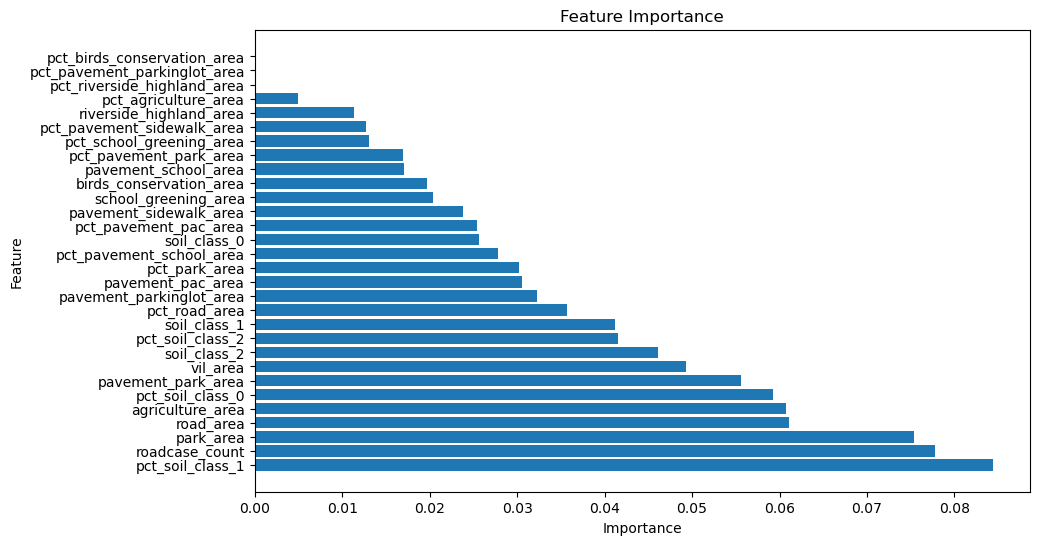

In [64]:
feature_importance = xgb_best_model.feature_importances_

# 获取特征名称
feature_names = X.columns  # 假设 X 是一个 DataFrame，每列代表一个特征

# 将特征重要性和特征名称组合成 DataFrame
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# 对特征重要性进行排序
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 输出特征重要性
print("Feature importance:")
print(feature_importance_df)

# 可视化特征重要性
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

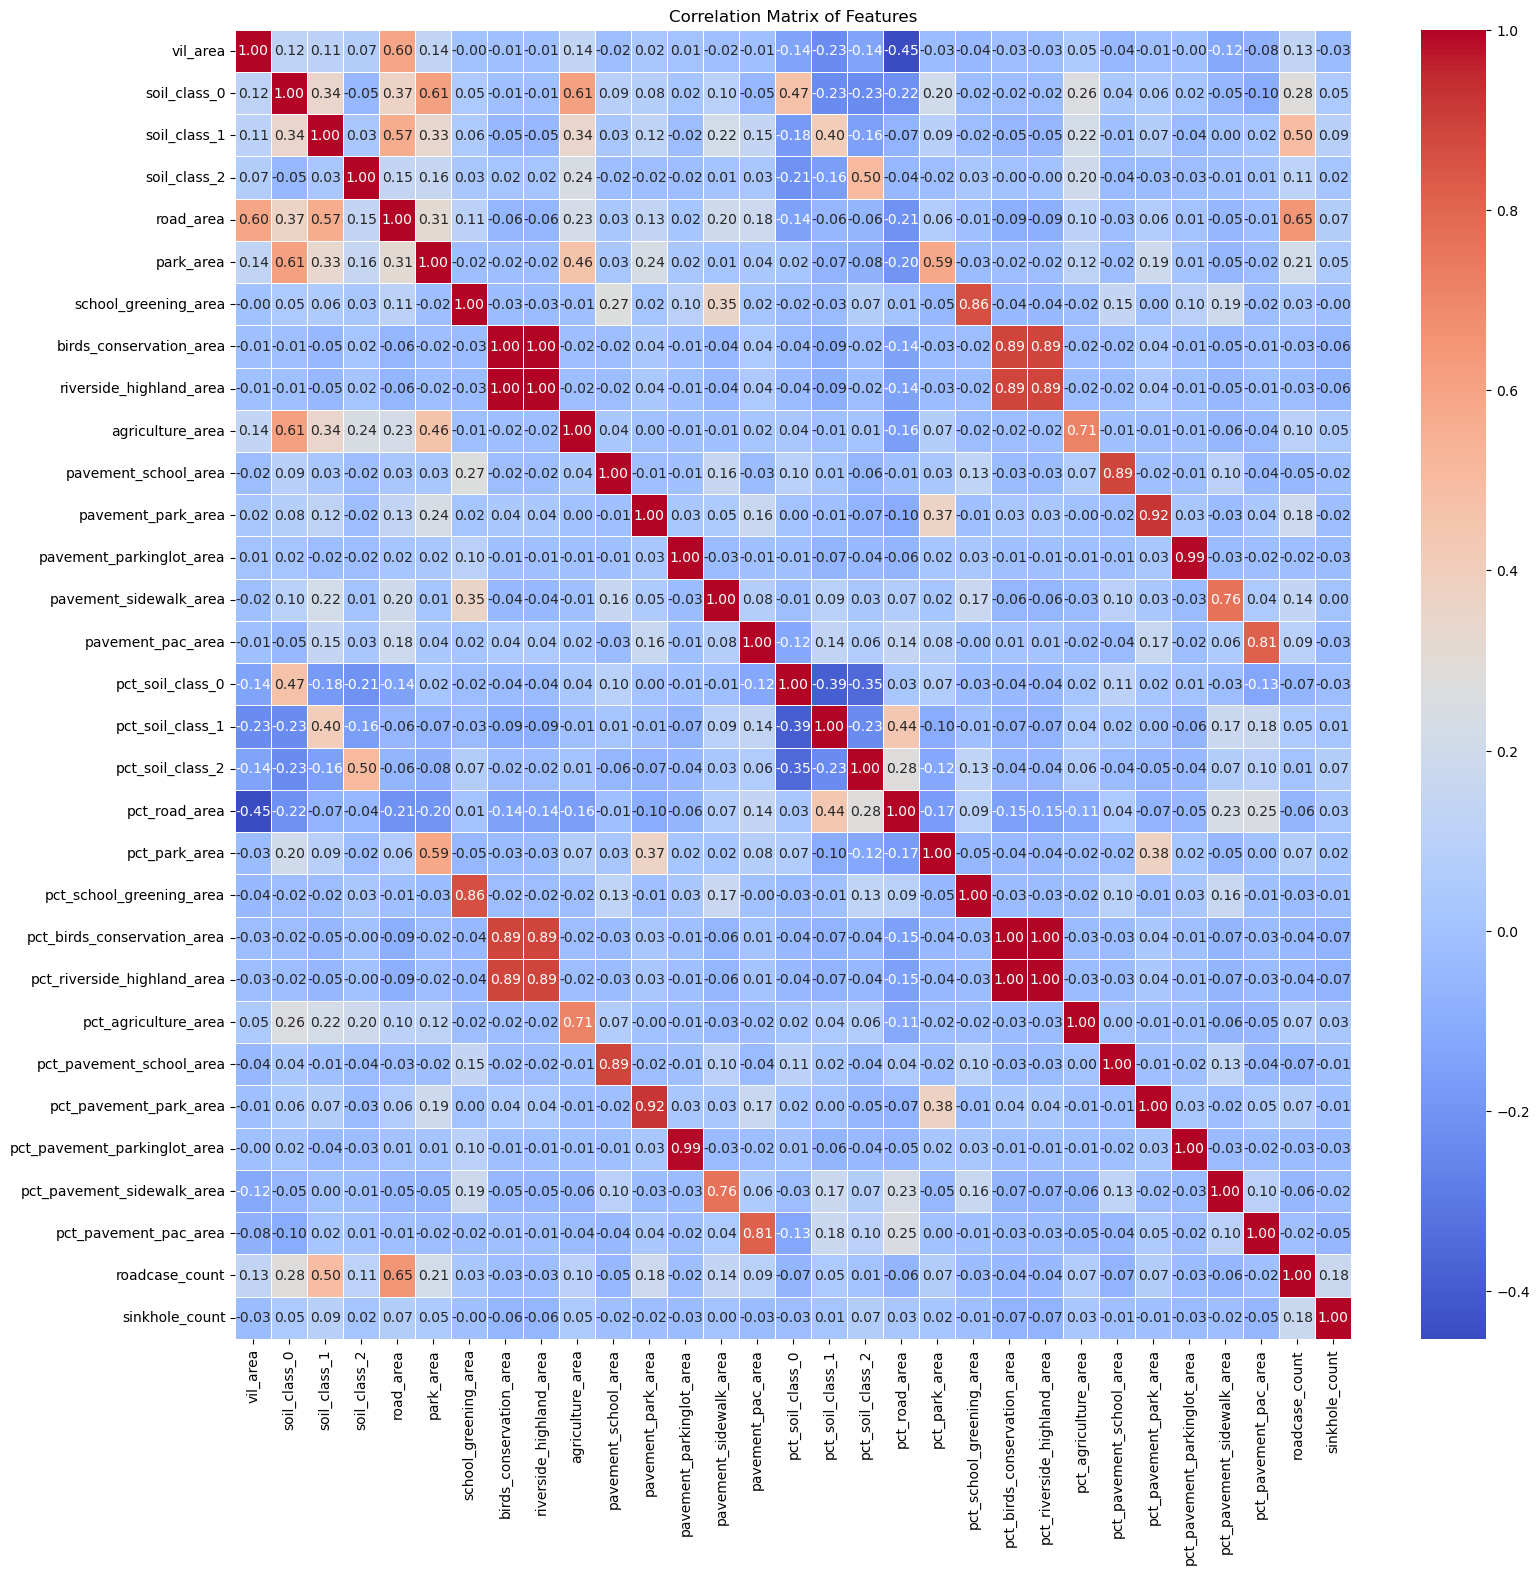

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 X 是特征数据，y 是目标变量
# X 应该是一个 DataFrame，每列代表一个特征

# 计算特征之间的相关系数矩阵
# drop_col = [col for col in tp_vil.columns if 'pct' in col]
X1 = tp_vil.iloc[:, 4:]
correlation_matrix = X1.corr()

# 可视化相关系数矩阵
plt.figure(figsize=(18, 17))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()
